In [ ]:
from fastai2.vision.all import *
from moving_mnist.models.conv_rnn import *
from moving_mnist.data import *

In [ ]:
torch.cuda.set_device(0)
torch.cuda.get_device_name()

'Quadro RTX 8000'

# Moving MNIST forecasting

> A little experiment using Convolutional RNNs to forecast moving MNIST digits.

## Install

It only uses fastai2 as dependency. Check how to install at https://github.com/fastai/fastai2

## Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: 3 objects

In [ ]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=3)

In [ ]:
train_tl = TfmdLists(range(500), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=8,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

Left: Input, Right: Target

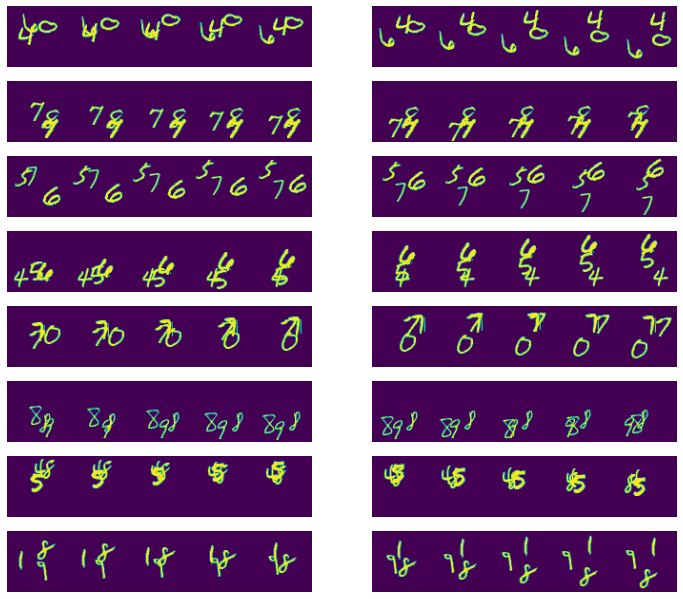

In [ ]:
dls.show_batch()

In [ ]:
model = SimpleModel()

In [ ]:
model

SimpleModel(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): TimeDistributed(
        (module): ConvLayer(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
      )
      (1): TimeDistributed(
        (module): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
        )
      )
      (2): TimeDistributed(
        (module): ConvLayer(
          (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): ReLU()
        )
      )
    )
    (rnns): ModuleList(
      (0): ConvGRU_cell(in=16, out=64, ks=5)
      (1): ConvGRU_cell(in=64, out=96, ks=5)
      (2): ConvGRU_cell(in=96, out=96, ks=5)
    )
  )
  (decoder): Decoder(
    (head): TimeDistributed(
      (module): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    )
    (deconvs): ModuleList(
      (0): TimeDistributed(
        (module): UpsampleBLock(in=96, out=96, blur=Fal

In [ ]:
class TargetSeq(Callback):
    def after_pred(self):
        self.learn.yb = (torch.stack(self.yb[0], dim=1),)

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat(), cbs=[TargetSeq()])

In [ ]:
x,y = dls.one_batch()

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=1.737800812406931e-05)

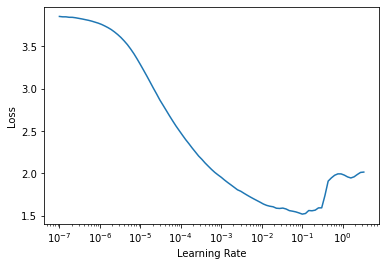

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,time
0,1.045332,0.872255,00:12
